# Cell Capacity
The battery data toolkit uses a simple defintion of the charge and discharge capacity of a battery with nuanced implications.
In short, we integrate the power and current moving out of the battery over time then 
use the maximum change from the start of the cycle to determine the capacity.
We illustrate the subtle parts below.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from batdata.postprocess.integral import StateOfCharge, CapacityPerCycle
from batdata.data import BatteryDataset

## Load Example Data
We have two simple cells that vary only by the where the "cycle" starts.

In [2]:
from_charged = BatteryDataset.from_batdata_hdf('../../tests/files/example-data/single-resistor-constant-charge_from-charged.hdf')

In [3]:
from_discharged = BatteryDataset.from_batdata_hdf('../../tests/files/example-data/single-resistor-constant-charge_from-discharged.hdf')

## Step 1: Intergrate Current and Power
First integrate the current ($I$) and power output ($IV$) of a battery to determine the amount of charge and energy transfered from the battery during each cycle.

The `StateOfCharge` tool in battery-data-toolkit computes these integrals.

In [4]:
charge = StateOfCharge()

In [5]:
charge.compute_features(from_charged);
charge.compute_features(from_discharged);

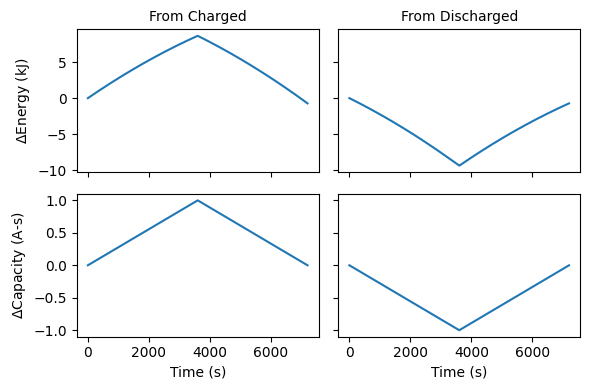

In [6]:
fig, axxs = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(6., 4.))

for axs, data, label in zip(axxs.T, [from_charged, from_discharged], ['Charged', 'Discharged']):
    axs[0].set_title(f'From {label}', fontsize=10)
    axs[0].plot(data.raw_data['test_time'], data.raw_data['cycle_energy'] / 1000.)
    axs[1].plot(data.raw_data['test_time'], data.raw_data['cycle_capacity'])

axxs[0, 0].set_ylabel('$\Delta$Energy (kJ)')
axxs[1, 0].set_ylabel('$\Delta$Capacity (A-s)')

for ax in axxs[-1, :]:
    ax.set_xlabel('Time (s)')

fig.tight_layout()

## Step 2: Assess Whether the Starting Point is Charged
We determine the starting point of the battery as "charged" or "discharged" as whether the maximum change from the start is positive or negative.
It's clear in the image above that the "from charged" battery releases charge in the beginning of the cycle before returning to zero, 
and the "from discharged" doe sthe opposite.

> Note: This definition assumes that a cycle returns a battery to as close to the initial charging state as possible.


## Step 3: Assign Capacities
We set capacities are using the maximum change from starting capacity, and 
the difference between that maximum and the change between the start and end of a cycle.
What each difference represents depends on whether the battery starts by discharging or charging.

In [7]:
capc = CapacityPerCycle()

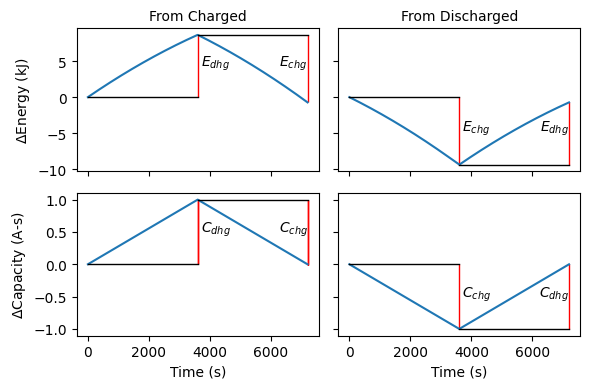

In [8]:
fig, axxs = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(6., 4.))

for axs, data, label in zip(axxs.T, [from_charged, from_discharged], ['Charged', 'Discharged']):
    capc.compute_features(data)

    # Start with the changes over time
    axs[0].set_title(f'From {label}', fontsize=10)
    axs[0].plot(data.raw_data['test_time'], data.raw_data['cycle_energy'] / 1000.)
    axs[1].plot(data.raw_data['test_time'], data.raw_data['cycle_capacity'])

    # Annotate the capacities/energies
    row = data.cycle_stats.iloc[0]
    axs[0].set_xlim(ax.get_xlim())
    for ax in axs:
        ax.plot([0, 3600], [0, 0], 'k-', lw=1)

    # Plot the energies
    for i, t in enumerate(['energy', 'capacity']):
        first_level = (row[f'discharge_{t}'] if label == 'Charged' else -row[f'charge_{t}'])
        if t == 'energy':
            first_level /= 1000.
        axs[i].arrow(3600, 0, 0, first_level, color='red')
        axs[i].text(3700, first_level / 2., '$' + t[0].upper() + '_{' + ("dhg" if label == "Charged" else "chg") + '}$')
    
        axs[i].plot([3600, 7200], [first_level] * 2, 'k-', lw=1)
        second_level = (row[f'discharge_{t}'] if label != 'Charged' else -row[f'charge_{t}'])
        if t == 'energy':
            second_level /= 1000.
        axs[i].arrow(7200, first_level, 0, second_level, color='red')
        axs[i].text(7200, first_level / 2., '$' + t[0].upper() + '_{' + ("dhg" if label != "Charged" else "chg") + '}$', ha='right')
    

axxs[0, 0].set_ylabel('$\Delta$Energy (kJ)')
axxs[1, 0].set_ylabel('$\Delta$Capacity (A-s)')

for ax in axxs[-1, :]:
    ax.set_xlabel('Time (s)')

fig.tight_layout()
fig.savefig('figures/explain-capacities.png', dpi=320)

The charge and discharge energies (or capacities) for the battery is the same for both cycles, we just have to look a different parts of the curve for each cycle.